# Preliminary exploration notebook

This notebook contains the following:
* Data loading and brief visualization
* Logistic regression
* CNN training and evaluation

In [ ]:
from google.colab import drive
drive.mount('/content/drive/') 

Mounted at /content/drive/


In [ ]:
import os # work with system    
import cv2 # work with images
import numpy as np # arrays and numerical analysis  
import matplotlib.pyplot as plt # for data plots

import sklearn.linear_model # linear models
from sklearn.model_selection import train_test_split # data splitting
from sklearn import metrics # model evaluation
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

os.chdir("drive/Shareddrives/Capstone 2023/Data/MicrosoftSnakeAlgorithmProject")


### set working directory in data folder
"""
assumes the following structure:
- MicrosoftSnakeAlgorithmProject
- Snakes-or-No-Snakes
    - *.ipynb (you are here)
"""
# os.chdir("../MicrosoftSnakeAlgorithmProject")
# os.chdir("../subset") # small proof of concept subset

'\nassumes the following structure:\n- MicrosoftSnakeAlgorithmProject\n- Snakes-or-No-Snakes\n    - *.ipynb (you are here)\n'

In [ ]:
counter = 0 # if desired to break loop

# labels and filenames should match since they are appended in order
filenames = []
labels = []

# one image does not open properly
empty_img = "MicrosoftSnakeAlgorithmProject/Snake_Images/FL_Snakes/WF8/IMG_7087.JPG"
# walk through all directories and files in current working directory
for root, dir, files in os.walk(os.getcwd()):
    
    for jpg in files:
        if empty_img in os.path.join(root, jpg):
          print(empty_img)
          continue

        # if jpg file, then keep filename
        if ".JPG" in jpg:
            filenames.append(os.path.join(root, jpg))

        if "Empty" in root:
          labels.append(0)
        elif "Snake" in root:
          labels.append(1)
            
    counter += 1
    # if counter > 10000: break
  
print(len(filenames))

MicrosoftSnakeAlgorithmProject/Snake_Images/FL_Snakes/WF8/IMG_7087.JPG
23275


In [ ]:
filenames_arr = np.array(filenames)
labels_arr = np.array(labels)

# split data: train is 1-test_size and test is test_size*leftover
x_train, x_test, y_train, y_test = train_test_split(
    filenames_arr, labels_arr, test_size = 0.2, stratify = labels_arr, shuffle = True, random_state = 27)

x_val, x_test, y_val, y_test = train_test_split(
    x_test, y_test, test_size = 0.75, stratify = y_test, shuffle = True, random_state = 27)

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(18620,)
(1163,)
(3492,)


In [ ]:
class data_generator(keras.utils.Sequence) :
  
  def __init__(self, image_filenames, labels, batch_size) :
    self.image_filenames = image_filenames
    self.labels = labels
    self.batch_size = batch_size
    
    
  def __len__(self) :
    return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(int)
  
  
  def __getitem__(self, idx) :
    batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]

    x_list = [cv2.resize(cv2.imread(file_name, cv2.IMREAD_GRAYSCALE), (512, 384), interpolation = cv2.INTER_NEAREST) for file_name in batch_x]
    x_arr = np.array(x_list)
    x_arr_reshaped = x_arr.reshape([x_arr.shape[0], x_arr.shape[1], x_arr.shape[2], 1])
    y_arr = np.array(batch_y)
    y_arr_reshaped = y_arr.reshape([x_arr_reshaped.shape[0], 1])

    return x_arr_reshaped, y_arr_reshaped

In [ ]:
batch_size = 32

my_training_batch_generator = data_generator(x_train, y_train, batch_size)
my_validation_batch_generator = data_generator(x_val, y_val, batch_size)
my_test_batch_generator = data_generator(x_test, y_test, batch_size)

In [ ]:
# create model 
def build_model():

    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(384, 512, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10))

    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-2,
        decay_steps=10000,
        decay_rate=0.9)
    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

    model.compile(
        optimizer = optimizer, loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
        metrics=['accuracy']
    )

    return model

In [ ]:
# build the model
cnn_model = build_model()

In [ ]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 382, 510, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 191, 255, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 189, 253, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 94, 126, 64)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 92, 124, 64)       36928     
                                                                 
 flatten_1 (Flatten)         (None, 730112)           

In [ ]:
cnn_fit = cnn_model.fit(
    my_training_batch_generator,
    steps_per_epoch = int(x_train.shape[0] // batch_size),
    epochs = 3,
    verbose = 1,
    validation_data = my_validation_batch_generator,
    validation_steps = int(x_val.shape[0] // batch_size)
)

Epoch 1/3
581/581 [==============================] - 9198s 16s/step - loss: 6.4309 - accuracy: 0.8525 - val_loss: 0.3080 - val_accuracy: 0.9071
Epoch 2/3
581/581 [==============================] - 8785s 15s/step - loss: 0.0680 - accuracy: 0.8248 - val_loss: 0.0179 - val_accuracy: 0.8194
Epoch 3/3
208/581 [=========>....................] - ETA: 1:31:42 - loss: 0.0144 - accuracy: 0.8140

In [ ]:
model_predict = cnn_model.predict(
    my_test_batch_generator,
)

<ipython-input-24-4fb8d3b79176>:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)


110/110 [==============================] - 434s 4s/step


In [ ]:
# get class predictions
predictions_cnn = np.argmax(model_predict, axis = -1) 
print(predictions_cnn.shape)

(3492,)


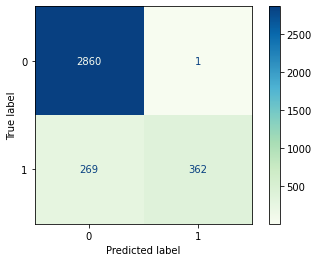

In [ ]:
# plot confusion matrix
metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictions_cnn, cmap = "GnBu")

In [ ]:
### model evaluation metrics 

# (true positive + true negative)/total
accuracy = sklearn.metrics.accuracy_score(y_test, predictions_cnn)
print(accuracy)

# true positive/(true positive + false positive)
precision = sklearn.metrics.precision_score(y_test, predictions_cnn)
print(precision)

# true positive/(true positive + false negative)
sensitivity = sklearn.metrics.recall_score(y_test, predictions_cnn)
print(sensitivity)

# true negative/(true negative + false positive)
specificity = sklearn.metrics.recall_score(y_test, predictions_cnn, pos_label = 0)
print(specificity)

# 2 * (precision*recall)/(precision+recall)
f1_score = 2*(precision*sensitivity)/(precision+sensitivity)
print(f1_score)

# no false positives means precision and specificity will be 100%

0.9226804123711341
0.9972451790633609
0.5736925515055468
0.999650471862985
0.7283702213279678


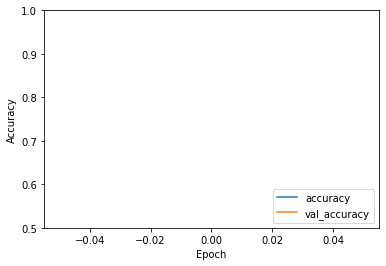

In [ ]:
# plot accuracy across epochs
plt.plot(cnn_fit.history['accuracy'], label='accuracy')
plt.plot(cnn_fit.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# plot accuracy across epochs
plt.plot(cnn_fit.history['accuracy'], label='accuracy')
plt.plot(cnn_fit.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# test_loss, test_acc = cnn_model.evaluate(x_test,  y_test, verbose=2)

In [ ]:
# # save model
# cnn_model.save('../Snakes-or-No-Snakes/cnn_alldata_1e')

## Below is original code, above is batched version

In [ ]:
images = []
counter2 = 0
# read in each image as grayscale (each is a 2d array)
for img in filenames:

    image = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    if image is None:
      print('Wrong path:', img)
    else:
      images.append(cv2.resize(image, (512, 384), interpolation = cv2.INTER_AREA))
      if "Empty" in root:
        labels.append(0)
      elif "Snake" in root:
        labels.append(1)

    counter2 += 1
    if counter2 % 100 == 0: print(counter2)
    # if counter2 > 100: break

# for image files, create label based on path: 0 means empty, 1 means snake
            

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

In [ ]:
print(len(images))
print(len(labels)) 

23275
23275


In [ ]:
# import pickle

# filepath = "/content/drive/MyDrive/images_resized.pkl" 
# with open(filepath,  'wb') as f:
#   pickle.dump(images, f)

NameError: ignored

In [ ]:
import pickle

filepath = "/content/drive/MyDrive/images_resized.pkl" 

with open(filepath, 'rb') as f:
    images = pickle.load(f)

In [ ]:
for i in range(len(images)):
  # print(images[i].shape)
  if images[i].shape != (512, 384):
    print(filenames[i])

## Image display
Uncomment cell below if you want to see the pictures as loaded via opencv (cv2)

In [ ]:
# # display image - will pop up in a separate window (seems to crash in colab)

# cv2.namedWindow("image1", cv2.WINDOW_NORMAL)
# cv2.imshow("image1", images[0])
# cv2.waitKey()

## Data processing

In [ ]:
import numpy as np
# convert to numpy arrays
image_arr = np.array(images)
label_arr = np.array(labels)
print(image_arr.shape)
print(label_arr.shape)

NameError: ignored

In [ ]:
# # scale data (currently broken) 
# scaler = sklearn.preprocessing.MinMaxScaler()
# image_scaled = scaler.fit_transform(image_arr)

## Logistic Regression

In [ ]:
# take colmean of each image to reduce features (for logistic regression)
image_reshape = image_arr.mean(axis=2)
print(image_reshape.shape)

(23275, 512)


In [ ]:
# scale data 
scaler = sklearn.preprocessing.MinMaxScaler()
image_scaled = scaler.fit_transform(image_reshape)

In [ ]:
# split data
x_train, x_test, y_train, y_test = train_test_split(
    image_reshape, label_arr, test_size = 0.4, stratify = label_arr, shuffle = True, random_state = 27)

x_val, x_test, y_val, y_test = train_test_split(
    x_test, y_test, test_size = 0.75, stratify = y_test, shuffle = True, random_state = 27)

In [ ]:
## initialize logistic regression model
# sag: stochastic average gradient descent, chosen for speed
log_model = sklearn.linear_model.LogisticRegression(solver = "sag", max_iter = 10000)
# fit model on train data
log_model.fit(x_train, y_train)

ValueError: ignored

In [ ]:
# plot confusion matrix
metrics.ConfusionMatrixDisplay.from_estimator(log_model, x_test, y_test,  cmap = "GnBu")

In [ ]:
### model evaluation metrics 
predictions = log_model.predict(x_test)

# (true positive + true negative)/total
accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
print(accuracy)

# true positive/(true positive + false positive)
precision = sklearn.metrics.precision_score(y_test, predictions)
print(precision)

# true positive/(true positive + false negative) aka recall
sensitivity = sklearn.metrics.recall_score(y_test, predictions)
print(sensitivity)

# true negative/(true negative + false positive)
specificity = sklearn.metrics.recall_score(y_test, predictions, pos_label = 0)
print(specificity)

# 2 * (precision*recall)/(precision+recall)
f1_score = 2*(precision*sensitivity)/(precision+sensitivity)
print(f1_score)

# no false positives means precision and specificity will be 100%

## CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

In [ ]:
# resize images else will run out of memory
image_resized = []
for image in image_arr:
  image_resized.append(cv2.resize(image, (0, 0), fx = 0.25, fy = 0.25, interpolation = cv2.INTER_AREA))

In [ ]:
# convert resized list into np array and scale
image_arr_resized = np.array(image_resized)
print(image_arr_resized.shape)

NameError: ignored

In [ ]:
# # display image - will pop up in a separate window (seems to crash in colab)

# cv2.namedWindow("image", cv2.WINDOW_NORMAL)
# cv2.imshow("image", image_arr_resized[0])
# cv2.waitKey()

In [ ]:
# # display image - will pop up in a separate window (seems to crash in colab)

# cv2.namedWindow("image", cv2.WINDOW_NORMAL)
# cv2.imshow("image", image_arr_resized[0])
# cv2.waitKey()

In [ ]:
# reshape for cnn
image_arr_reshaped = image_arr_resized.reshape([image_arr_resized.shape[0], image_arr_resized.shape[1], image_arr_resized.shape[2], 1])
label_arr_reshaped = label_arr.reshape([image_arr_resized.shape[0], 1])

IndexError: ignored

In [ ]:
# reshape for cnn
image_arr_reshaped = image_arr.reshape([image_arr.shape[0], image_arr.shape[1], image_arr.shape[2], 1])
label_arr_reshaped = label_arr.reshape([image_arr.shape[0], 1])

In [ ]:
# split data: train is 1-test_size and val, test are equal in size
x_train, x_test, y_train, y_test = train_test_split(
    image_arr_reshaped, label_arr_reshaped, test_size = 0.4, stratify = label_arr_reshaped, shuffle = True, random_state = 27)

x_val, x_test, y_val, y_test = train_test_split(
    x_test, y_test, test_size = 0.75, stratify = y_test, shuffle = True, random_state = 27)

In [ ]:
# create model (stock from keras documentation for now)
def build_model():

    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_arr_resized.shape[1], image_arr_resized.shape[2], 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10))

    model.compile(
        optimizer = "adam", loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
        metrics=['accuracy']
    )

    return model

In [ ]:
# build the model
cnn_model = build_model()

# or load saved (see google drive models folder for download)
# cnn_model = tf.keras.models.load_model("../Snakes-or-No-Snakes/cnn_v2/")

In [ ]:
# train the model
cnn_fit = cnn_model.fit(x_train, y_train, epochs=7, 
                        validation_data=(x_val, y_val))

In [ ]:
# get class predictions
predictions_cnn = np.argmax(cnn_model.predict(x_test), axis = -1) 
print(predictions_cnn.shape)

In [ ]:
# plot confusion matrix
metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictions_cnn, cmap = "GnBu")

In [ ]:
### model evaluation metrics 

# (true positive + true negative)/total
accuracy = sklearn.metrics.accuracy_score(y_test, predictions_cnn)
print(accuracy)

# true positive/(true positive + false positive)
precision = sklearn.metrics.precision_score(y_test, predictions_cnn)
print(precision)

# true positive/(true positive + false negative)
sensitivity = sklearn.metrics.recall_score(y_test, predictions_cnn)
print(sensitivity)

# true negative/(true negative + false positive)
specificity = sklearn.metrics.recall_score(y_test, predictions_cnn, pos_label = 0)
print(specificity)

# 2 * (precision*recall)/(precision+recall)
f1_score = 2*(precision*sensitivity)/(precision+sensitivity)
print(f1_score)

# no false positives means precision and specificity will be 100%

In [ ]:
# plot accuracy across epochs
plt.plot(cnn_fit.history['accuracy'], label='accuracy')
plt.plot(cnn_fit.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = cnn_model.evaluate(x_test,  y_test, verbose=2)

In [ ]:
# save model
cnn_model.save('../Snakes-or-No-Snakes/cnn_v3')